In [ ]:
!pip install labml_helpers

In [ ]:
!pip install labml_nn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.clip_grad import clip_grad_value_
from labml_nn.gan.wasserstein.gradient_penalty import GradientPenalty
import random

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

# Set random seed for reproducibility
manualSeed = 1337
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)

### Creating config object (argparse workaround)

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [ ]:
len(dataloader)

In [ ]:
for image, cat in dataloader:
  print(image.shape, cat.shape)
  break

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [ ]:
image.size()

torch.Size([16, 1, 28, 28])

In [ ]:
28*28

784

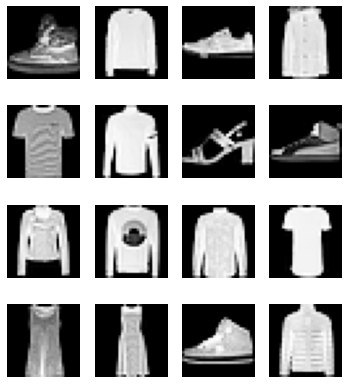

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Create generator and discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

input.shape, noise.shape, fixed_noise.shape, label.shape

### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

### GAN

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 5
config.noise_size = 50
config.print_freq = 100

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
generator = Generator()
discriminator = Discriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()


for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)

        errD_x = criterion(output, label)

        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.24 errD_z: 0.18 errG: 1.91
Epoch:1 Iter: 200 errD_x: 0.25 errD_z: 0.11 errG: 2.33
Epoch:1 Iter: 300 errD_x: 0.43 errD_z: 0.20 errG: 1.84
Epoch:1 Iter: 400 errD_x: 0.13 errD_z: 0.13 errG: 2.27
Epoch:1 Iter: 500 errD_x: 0.08 errD_z: 0.09 errG: 2.64
Epoch:1 Iter: 600 errD_x: 0.59 errD_z: 0.04 errG: 3.15
Epoch:1 Iter: 700 errD_x: 0.12 errD_z: 0.10 errG: 2.69
Epoch:1 Iter: 800 errD_x: 0.06 errD_z: 0.13 errG: 2.61
Epoch:1 Iter: 900 errD_x: 0.32 errD_z: 0.20 errG: 1.80
Epoch:1 Iter: 1000 errD_x: 0.31 errD_z: 0.24 errG: 1.84
Epoch:1 Iter: 1100 errD_x: 0.20 errD_z: 0.24 errG: 1.98
Epoch:1 Iter: 1200 errD_x: 0.45 errD_z: 0.14 errG: 2.32
Epoch:1 Iter: 1300 errD_x: 0.31 errD_z: 0.15 errG: 2.21
Epoch:1 Iter: 1400 errD_x: 0.14 errD_z: 0.24 errG: 1.86
Epoch:1 Iter: 1500 errD_x: 0.29 errD_z: 0.25 errG: 1.87
Epoch:1 Iter: 1600 errD_x: 0.28 errD_z: 0.19 errG: 2.01
Epoch:1 Iter: 1700 errD_x: 0.15 errD_z: 0.17 errG: 2.40
Epoch:1 Iter: 1800 errD_x: 0.20 errD_z: 0.18 errG: 2.37
E

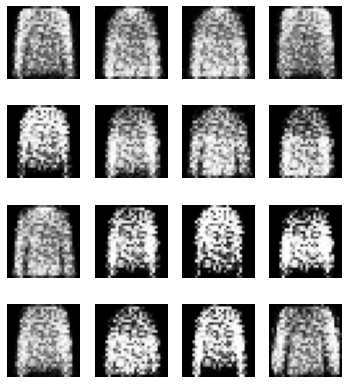

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

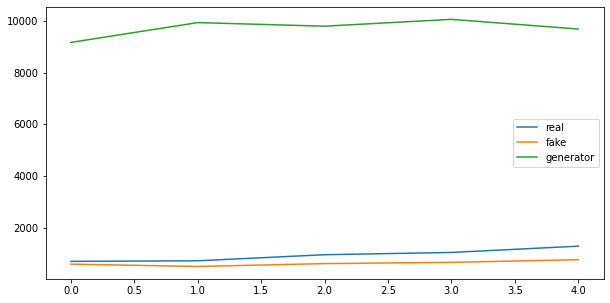

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()

### WGAN weigth clipping

In [ ]:
class DiscriminatorLoss(nn.Module):
  def forward(self, data: torch.Tensor):
    return data.mean()

class GeneratorLoss(nn.Module):
  def forward(self, fake: torch.Tensor):
    return -fake.mean()

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 5
config.noise_size = 50
config.print_freq = 100

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
generator = Generator()
discriminator = Discriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion_D = DiscriminatorLoss()
criterion_G = GeneratorLoss()


for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        error_real = criterion_D(output)
        ERRD_x[epoch] += error_real.item()

        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)

        output = discriminator(fake.detach())
        error_fake = criterion_D(output)
        ERRD_z[epoch] += error_fake.item()

        errD = - (error_real - error_fake)
        errD.backward()
        optim_D.step()

        for p in discriminator.parameters():
          p.data.clamp_(-0.01, 0.01)
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion_G(output)
        ERRG[epoch] += errG.item()
        
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.4f} errG: {:.4f}'.format(epoch+1,
                                                                            iteration+1, 
                                                                            errD, 
                                                                            errG.item()))

Epoch:1 Iter: 100 errD: -0.0230 errG: -0.4816
Epoch:1 Iter: 200 errD: -0.0383 errG: -0.4573
Epoch:1 Iter: 300 errD: -0.0245 errG: -0.4540
Epoch:1 Iter: 400 errD: -0.0256 errG: -0.4709
Epoch:1 Iter: 500 errD: -0.0184 errG: -0.4838
Epoch:1 Iter: 600 errD: -0.0270 errG: -0.4934
Epoch:1 Iter: 700 errD: -0.0281 errG: -0.4988
Epoch:1 Iter: 800 errD: -0.0265 errG: -0.4940
Epoch:1 Iter: 900 errD: -0.0244 errG: -0.5006
Epoch:1 Iter: 1000 errD: -0.0311 errG: -0.5021
Epoch:1 Iter: 1100 errD: -0.0138 errG: -0.5107
Epoch:1 Iter: 1200 errD: -0.0063 errG: -0.5044
Epoch:1 Iter: 1300 errD: -0.0157 errG: -0.5045
Epoch:1 Iter: 1400 errD: -0.0181 errG: -0.5028
Epoch:1 Iter: 1500 errD: -0.0050 errG: -0.4984
Epoch:1 Iter: 1600 errD: -0.0093 errG: -0.4918
Epoch:1 Iter: 1700 errD: -0.0110 errG: -0.5029
Epoch:1 Iter: 1800 errD: -0.0183 errG: -0.5051
Epoch:1 Iter: 1900 errD: -0.0081 errG: -0.5060
Epoch:1 Iter: 2000 errD: -0.0109 errG: -0.4995
Epoch:1 Iter: 2100 errD: -0.0132 errG: -0.4966
Epoch:1 Iter: 2200 err

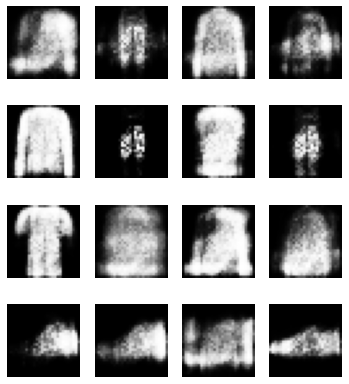

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

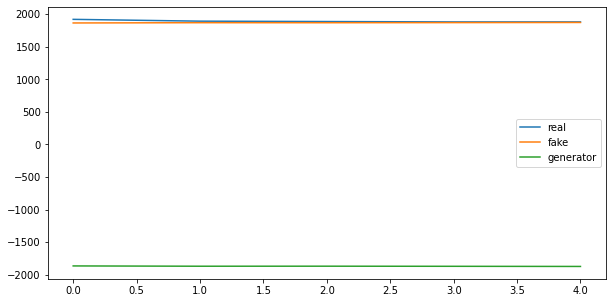

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()

### WGAN GP

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

input.shape, noise.shape, fixed_noise.shape, label.shape

In [ ]:
class DiscriminatorLoss(nn.Module):
  def forward(self, data: torch.Tensor):
    return data.mean()

class GeneratorLoss(nn.Module):
  def forward(self, fake: torch.Tensor):
    return -fake.mean()

# class GradientPenalty(nn.Module):
#   def forward(self, real: torch.Tensor, fake: torch.Tensor):
#     
#     print(real.shape)
#     batch_size = real.shape[0]
#     gradients, *_ = torch.autograd.grad(
#       outputs=fake,
#       inputs=real,
#       grad_outputs=fake.new_ones(fake.shape),
#       create_graph=True
#     )
#     gradients = gradients.reshape(batch_size, -1)
#     norm = gradients.norm(2, dim=-1)

    # return torch.mean((norm - 1) ** 2)

In [ ]:
# 1

class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 5
config.noise_size = 50
config.print_freq = 100
config.lambd = 10
config.d_iters = 3

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
generator = Generator()
discriminator = Discriminator()
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001, betas=(0.0, 0.9))

GP = GradientPenalty()

# criterion_D = DiscriminatorLoss()
criterion_G = GeneratorLoss()


for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        for _ in range(config.d_iters):
          discriminator.zero_grad()
          
          # real
          label.data.fill_(real_label)
          input_data = images.view(images.shape[0], -1)

          input_data.requires_grad_()
          output_real = discriminator(input_data)
          
          # error_real = criterion_D(output_real)
          error_real = torch.mean(output_real)
          ERRD_x[epoch] += error_real.item()

          
          # fake 
          noise.data.normal_(0, 1)
          fake = generator(noise)

          label.data.fill_(fake_label)

          output_fake = discriminator(fake.detach())
          # error_fake = criterion_D(output_fake)
          error_fake = torch.mean(output_fake)
          
          ERRD_z[epoch] += error_fake.item()

          gp = GP(input_data, output_real)
          errD = (
              -(error_real - error_fake) + config.lambd * gp
          )
          errD.backward(retain_graph=True)
          optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = -torch.mean(output)
        ERRG[epoch] += errG.item()
        
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD: {:.4f} er_real: {:.4f} er_fake: {:.4f} errG: {:.4f}'.format(epoch+1,
                                                                            iteration+1,
                                                                            errD, 
                                                                            error_real,
                                                                            error_fake, 
                                                                            errG.item()))

Epoch:1 Iter: 100 errD: 4.8210 er_real: 0.5127 er_fake: 0.3037 errG: -0.3054
Epoch:1 Iter: 200 errD: 6.6815 er_real: 0.5232 er_fake: 0.1293 errG: -0.1224
Epoch:1 Iter: 300 errD: 5.8148 er_real: 0.4528 er_fake: 0.0196 errG: -0.0279
Epoch:1 Iter: 400 errD: 5.7018 er_real: 0.5122 er_fake: 0.0104 errG: -0.0101
Epoch:1 Iter: 500 errD: 5.1807 er_real: 0.4969 er_fake: 0.0529 errG: -0.0521
Epoch:1 Iter: 600 errD: 3.3469 er_real: 0.4353 er_fake: 0.0897 errG: -0.0969
Epoch:1 Iter: 700 errD: 4.4978 er_real: 0.5051 er_fake: 0.5830 errG: -0.5811
Epoch:1 Iter: 800 errD: 6.4125 er_real: 0.4558 er_fake: 0.2443 errG: -0.2472
Epoch:1 Iter: 900 errD: 8.2733 er_real: 0.5178 er_fake: 0.5272 errG: -0.5272
Epoch:1 Iter: 1000 errD: 9.6901 er_real: 0.5251 er_fake: 0.5174 errG: -0.5169
Epoch:1 Iter: 1100 errD: 9.7854 er_real: 0.5234 er_fake: 0.5223 errG: -0.5223
Epoch:1 Iter: 1200 errD: 9.4419 er_real: 0.5233 er_fake: 0.5197 errG: -0.5197
Epoch:1 Iter: 1300 errD: 9.9815 er_real: 0.5147 er_fake: 0.5144 errG: -0.

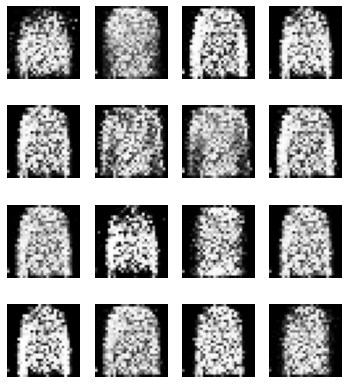

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

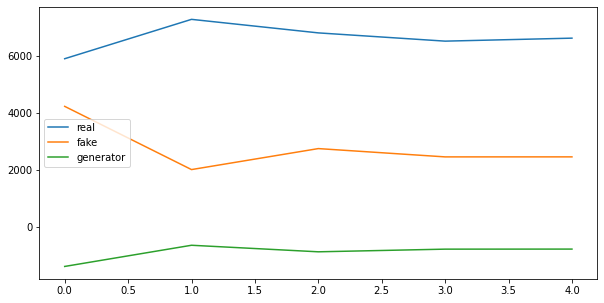

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()

### CondGAN

In [ ]:
class CondGenerator(nn.Module):
    def __init__(self):
        super(CondGenerator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        self.label_emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)
    
class CondDiscriminator(nn.Module):
    def __init__(self):
        super(CondDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid()
        )
        self.label_emb = nn.Embedding(10, 10)
    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100
config.lambd = 10

generator = CondGenerator()
discriminator = CondDiscriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        fake_cat = Variable(torch.LongTensor(np.random.randint(0, 10, config.batch_size)))
        label.data.fill_(fake_label)
        noise.data.normal_(0, 1)
        fake = generator(noise, fake_cat)
        output = discriminator(fake.detach(), fake_cat)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        label.data.fill_(real_label)
        generator.zero_grad()
        output = discriminator(fake, fake_cat)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                        iteration+1, 
                                                                                        errD_x.item(),
                                                                                        errD_z.item(), 
                                                                                        errG.item()))

Epoch:1 Iter: 100 errD_x: 0.28 errD_z: 0.12 errG: 2.21
Epoch:1 Iter: 200 errD_x: 0.34 errD_z: 0.23 errG: 2.11
Epoch:1 Iter: 300 errD_x: 0.28 errD_z: 0.19 errG: 1.98
Epoch:1 Iter: 400 errD_x: 0.15 errD_z: 0.10 errG: 2.49
Epoch:1 Iter: 500 errD_x: 0.14 errD_z: 0.11 errG: 2.43
Epoch:1 Iter: 600 errD_x: 0.33 errD_z: 0.11 errG: 2.46
Epoch:1 Iter: 700 errD_x: 0.25 errD_z: 0.19 errG: 2.16
Epoch:1 Iter: 800 errD_x: 0.16 errD_z: 0.15 errG: 2.40
Epoch:1 Iter: 900 errD_x: 0.30 errD_z: 0.10 errG: 2.78
Epoch:1 Iter: 1000 errD_x: 0.10 errD_z: 0.11 errG: 2.79
Epoch:1 Iter: 1100 errD_x: 0.70 errD_z: 0.17 errG: 2.49
Epoch:1 Iter: 1200 errD_x: 0.15 errD_z: 0.15 errG: 2.67
Epoch:1 Iter: 1300 errD_x: 0.17 errD_z: 0.18 errG: 2.68
Epoch:1 Iter: 1400 errD_x: 0.47 errD_z: 0.32 errG: 2.44
Epoch:1 Iter: 1500 errD_x: 0.65 errD_z: 0.20 errG: 2.28
Epoch:1 Iter: 1600 errD_x: 0.19 errD_z: 0.19 errG: 2.44
Epoch:1 Iter: 1700 errD_x: 0.18 errD_z: 0.18 errG: 2.82
Epoch:1 Iter: 1800 errD_x: 0.22 errD_z: 0.13 errG: 2.68
E

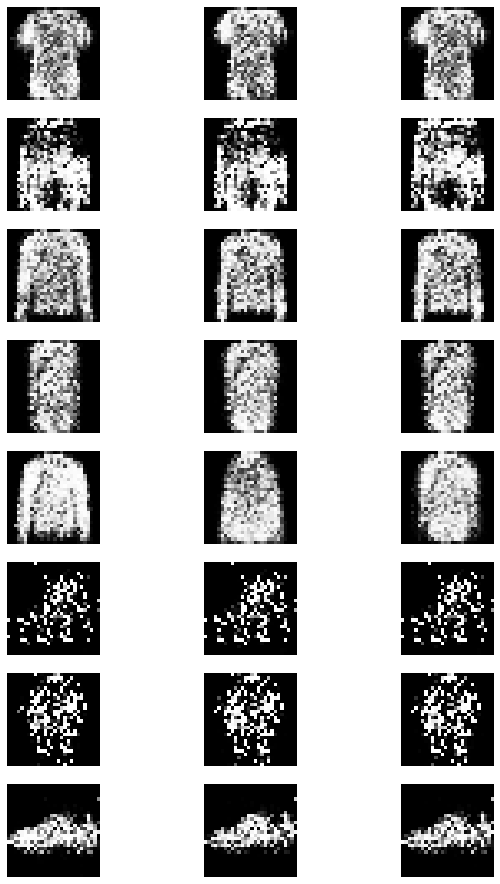

In [ ]:
noise.data.normal_(0, 1)
fake_labels = torch.LongTensor(list(range(10)) + list(range(6)))

fake = []
for i in range(3):
    noise.data.normal_(0, 1)
    fake.append(generator(noise, fake_labels))

enum = [(0, 1, 2)] * 8
plt.figure(figsize=(10, 16))
for i, cnt in zip(range(0, 22, 3), enum):
  for j in cnt:
    plt.subplot(8, 3, i + j + 1)
    plt.imshow(fake[j][i//3].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [ ]:
enum = [(1, 2, 3)] * 8

for i, cnt in zip(range(0,22,3), enum):
  print(i, cnt)

0 (1, 2, 3)
3 (1, 2, 3)
6 (1, 2, 3)
9 (1, 2, 3)
12 (1, 2, 3)
15 (1, 2, 3)
18 (1, 2, 3)
21 (1, 2, 3)


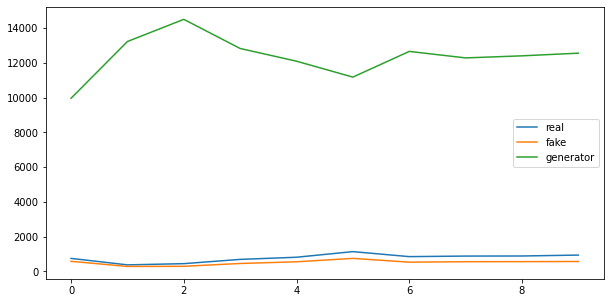

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(ERRD_x, label="real")
plt.plot(ERRD_z, label="fake")
plt.plot(ERRG, label="generator")
plt.legend()
plt.show()